## COVID-19 Vaccine sentiment analysis vs vaccination rate.

__Research Question:__
    I an trying to determine if there is a corrolation between the sentiment towards the vaccine on Twitter with 
    the rate at which people are getting vaccinated. 
    
I will be scraping a collection of tweets from that last week that pretain to COVID-19 and the vaccine. From this data set I will run a word frequency analysis and a Vader Sentiment analysis in order to determine the attitude towards teh vaccine on Twitter.   



In [15]:
import requests
import urllib
import json
import pandas as pd
import time
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import warnings
import nltk
from nltk import tokenize as tk
from nltk import FreqDist
from nltk.corpus import stopwords
import string
from matplotlib import pyplot as plt

In [2]:
tokens = pd.read_csv('/Users/ethanhancock/Documents/Twitter-Keys.txt', sep = '\t', header = None).T
tokens.columns = tokens.iloc[0]
tokens = tokens[1:]
#tokens.Bearer_Token[1]

In [3]:
def auth():
    return tokens.Bearer_Token[1]

In [4]:
def create_url():
    query = urllib.parse.quote('(vaccine) OR #vaccine OR #COVID #vaccine OR (COVID-19 vaccine) OR vaccines OR #vaccines OR (COVID-19 vaccines) OR (COVID vaccine) OR (COVID vaccines) -is:retweet')
    tweet_fields = 'tweet.fields=author_id,geo,lang,text,id'
    url = 'https://api.twitter.com/2/tweets/search/recent?query={}&{}'.format(query, tweet_fields)
    return url

print(create_url())

https://api.twitter.com/2/tweets/search/recent?query=%28vaccine%29%20OR%20%23vaccine%20OR%20%23COVID%20%23vaccine%20OR%20%28COVID-19%20vaccine%29%20OR%20vaccines%20OR%20%23vaccines%20OR%20%28COVID-19%20vaccines%29%20OR%20%28COVID%20vaccine%29%20OR%20%28COVID%20vaccines%29%20-is%3Aretweet&tweet.fields=author_id,geo,lang,text,id


In [5]:
def create_headers(bearer_token):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    return headers

#print(create_headers(tokens.Bearer_Token[1]))

In [6]:
def connect_to_endpoint(url, headers):
    response = requests.request("GET", url, headers=headers)
    print(response.status_code)
    if response.status_code !=200:
        raise Exception(response.status_code, response.text)
    return response.json()

In [7]:
def one_request():
    bearer_token = auth()
    url = create_url()
    headers = create_headers(bearer_token)
    json_response = connect_to_endpoint(url, headers)
    return json_response

In [8]:
results = one_request()

200


In [9]:
results.keys()

dict_keys(['data', 'meta'])

In [10]:
tweet_dat = pd.DataFrame(results['data'])

In [11]:
tweet_dat

,text,lang,author_id,id
0,RT @jaysaran: TPBS สรุปเรื่อง vaccine\n\nModer...,th,1282983073,1389443224482107393
1,RT @lindyli: The most vaccine-hesitant group i...,en,1296108183233212417,1389443224373276673
2,Yes except my BFF was charged $80 for the vacc...,en,3300565685,1389443223031099393
3,RT @lapublichealth: LA County has administered...,en,26353005,1389443222636695552
4,RT @Lauren38060467: Here we are people: vaccin...,en,1345244276305891328,1389443221340700672
5,RT @GovRonDeSantis: I was proud to sign landma...,en,1314869569,1389443221126885376
6,RT @aznbolshygirl: san jose is handing out fre...,en,2157400957,1389443221047107585
7,Can someone investigate #vaccine distribution ...,en,1623799867,1389443220581486594
8,"RT @wolfofnewstreet: Hmm, abeg what did Melind...",en,3764282667,1389443219977551874
9,RT @rozlatiff: Malaysia has set the dosing int...,en,606943,1389443219511906305


To collect the data I used the Twitter API to collect tweets that included key words that would suggest they are associated with the COVID-19 vaccine. A myriad of combinations of the word vaccine with COVID-19 and vaccine separetly as well. 

In [12]:
def create_url_pag(next_token = None):
    if (next_token):
        query = urllib.parse.quote('(vaccine) OR #vaccine OR #COVID #vaccine OR (COVID-19 vaccine) OR vaccines OR #vaccines OR (COVID-19 vaccines) OR (COVID vaccine) OR (COVID vaccines) -is:retweet')
        tweet_fields = 'tweet.fields=author_id,geo,lang,text,id'
        pagination = str(next_token)
        url = 'https://api.twitter.com/2/tweets/search/recent?query={}&next_token={}&{}'.format(query, pagination, tweet_fields)
        return url
    else:
        query = urllib.parse.quote('(vaccine) OR #vaccine OR #COVID #vaccine OR (COVID-19 vaccine) OR vaccines OR #vaccines OR (COVID-19 vaccines) OR (COVID vaccine) OR (COVID vaccines) -is:retweet')
        tweet_fields = 'tweet.fields=author_id,geo,lang,text,id'
        url = 'https://api.twitter.com/2/tweets/search/recent?query={}&{}'.format(query, tweet_fields)
        return url
print(create_url_pag(None))
print(create_url_pag('000000000000000'))

https://api.twitter.com/2/tweets/search/recent?query=%28vaccine%29%20OR%20%23vaccine%20OR%20%23COVID%20%23vaccine%20OR%20%28COVID-19%20vaccine%29%20OR%20vaccines%20OR%20%23vaccines%20OR%20%28COVID-19%20vaccines%29%20OR%20%28COVID%20vaccine%29%20OR%20%28COVID%20vaccines%29%20-is%3Aretweet&tweet.fields=author_id,geo,lang,text,id
https://api.twitter.com/2/tweets/search/recent?query=%28vaccine%29%20OR%20%23vaccine%20OR%20%23COVID%20%23vaccine%20OR%20%28COVID-19%20vaccine%29%20OR%20vaccines%20OR%20%23vaccines%20OR%20%28COVID-19%20vaccines%29%20OR%20%28COVID%20vaccine%29%20OR%20%28COVID%20vaccines%29%20-is%3Aretweet&next_token=000000000000000&tweet.fields=author_id,geo,lang,text,id


In [28]:
def pages():
    count = 0
    status = True
    next_token = None
    dat = pd.DataFrame()
    while status:
        try:
            bearer_token = auth()
            url = create_url_pag(next_token)
            headers = create_headers(bearer_token)
            json_response = connect_to_endpoint(url, headers)
            next_token = json_response['meta']['next_token']
            if(count < 3):
                dat = dat.append(pd.DataFrame(json_response['data']))
            else:
                status = False
        except:
            count = count + 1
            time.sleep(900)
    return dat

In [30]:
pages = pages()

200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200


In [31]:
len(pages.id)

13493

I collected 13493 tweets. Each tweet has an author id which identifies the author of the tweet, the id which is the tweet's individual identifier, the text that is the actual tweet, the lang which is the language the tweet is written in, and the geo which is a location mentioned in the tweet. 

In [32]:
pages.head(40)

,id,text,author_id,lang,withheld,geo
0,1389462584471007232,RT @Portes_Thomas: Les lycéens se mobilisent p...,522464657,fr,NaN,NaN
1,1389462583250329601,RT @CNN: There have been more Covid-19 cases r...,452473850,en,NaN,NaN
2,1389462582432464899,"@mla_sudhakar Hello sir, I visited one of the ...",3401360113,en,NaN,NaN
3,1389462582268944385,"RT @wolfofnewstreet: Hmm, abeg what did Melind...",4122258611,en,NaN,NaN
4,1389462582130511872,RT @PuangSad: ยายได้คิวฉีด Vaccine Astrazeneca...,884882329,th,NaN,NaN
5,1389462581388087305,RT @CaptMarkKelly: Important news: You can now...,820384458633191424,en,NaN,NaN
6,1389462580201152518,RT @jedi_fu: Apparently the people making mone...,1348965994388201472,en,NaN,NaN
7,1389462580083703812,RT @FaheemYounus: How Vaccine Can Liberate You...,1126568439634591744,en,NaN,NaN
8,1389462579945164803,RT @abramovitzra: Banned from YouTube: Dr. Sim...,1078949226,en,NaN,NaN
9,1389462579928576002,RT @kellygrant1: I wrote today about infection...,258652587,en,NaN,NaN


In [34]:
pages.to_csv('covid_twitter_data.csv')

Above I saved the data that I collected from Twitter to a CSV file to easily access the data in the future. Below I am reading in the csv file I created so I do not have to call twitter data again.

In [4]:
tweets = pd.read_csv('covid_twitter_data.csv')

In [49]:
en_only = tweets.loc[tweets['lang'] == 'en']
en_only

,Unnamed: 0,id,text,author_id,lang,withheld,geo
1,1,1389462583250329601,RT @CNN: There have been more Covid-19 cases r...,452473850,en,NaN,NaN
2,2,1389462582432464899,"@mla_sudhakar Hello sir, I visited one of the ...",3401360113,en,NaN,NaN
3,3,1389462582268944385,"RT @wolfofnewstreet: Hmm, abeg what did Melind...",4122258611,en,NaN,NaN
5,5,1389462581388087305,RT @CaptMarkKelly: Important news: You can now...,820384458633191424,en,NaN,NaN
6,6,1389462580201152518,RT @jedi_fu: Apparently the people making mone...,1348965994388201472,en,NaN,NaN
...,...,...,...,...,...,...,...
13484,1,1389456286853435393,RT @zainrizvi: @gregggonsalves @apoorva_nyc @J...,538467434,en,NaN,NaN
13487,4,1389456285385383937,WATCH | Taguig healthcare workers begin to adm...,823349574739734528,en,NaN,NaN
13490,7,1389456282780934144,RT @mohanrajtn: Short of Vaccines!\n@adarpoona...,972517581688115201,en,NaN,NaN
13491,8,1389456282759974915,RT @DrEmbrace: I was vaccine injured in the US...,1025997723630071808,en,NaN,NaN


After collecting the tweets I stripped out all of the tweets that were not in english according to Twitter so that they would not interfear with the Vader sentiment analysis

In [51]:
en_only['text_lower'] = [x.lower() for x in en_only['text']]
en_only['text_lower'].head(20)

<ipython-input-51-0e8045c07386>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_only['text_lower'] = [x.lower() for x in en_only['text']]


1     rt @cnn: there have been more covid-19 cases r...
2     @mla_sudhakar hello sir, i visited one of the ...
3     rt @wolfofnewstreet: hmm, abeg what did melind...
5     rt @captmarkkelly: important news: you can now...
6     rt @jedi_fu: apparently the people making mone...
7     rt @faheemyounus: how vaccine can liberate you...
8     rt @abramovitzra: banned from youtube: dr. sim...
9     rt @kellygrant1: i wrote today about infection...
10    rt @rohini_sgh: dear @drharshvardhan- if you a...
11    rt @booker4ky: big pharma greed vs saving live...
14    rt @dyradyre: they’ll provide. when you come, ...
15    rt @toofab: while mccain is fully vaccinated, ...
16    rt @gavaruzzi: excellent point! filling the "k...
17    rt @cnni: the us food and drug administration ...
18    rt @vanitajain21: first reaction after second ...
19    rt @globalhlthtwit: many millions will die thi...
20       i have a joke on vaccine but its only for 18+.
22    rt @thewellunc: a decade of mrna research 

In [52]:
en_only['tokens'] = [tk.word_tokenize(x) for x in en_only['text_lower']]
en_only['tokens'].head(5)

<ipython-input-52-2a016fabcec5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_only['tokens'] = [tk.word_tokenize(x) for x in en_only['text_lower']]


1    [rt, @, cnn, :, there, have, been, more, covid...
2    [@, mla_sudhakar, hello, sir, ,, i, visited, o...
3    [rt, @, wolfofnewstreet, :, hmm, ,, abeg, what...
5    [rt, @, captmarkkelly, :, important, news, :, ...
6    [rt, @, jedi_fu, :, apparently, the, people, m...
Name: tokens, dtype: object

Above I converted all of the tweets into lowercase to normalize the text and only take into account the words in the tweets and also to have more accurate word frequency results. I then tockenized the tweets to break apart the tweets to run a frequency analysis. I also added stopwords to the list in order to remove words or punctuations that are not releavant to the converstaion. 

In [114]:
mystopwords = stopwords.words('english')
mystopwords.append("n't")
mystopwords.append("'s")
mystopwords.append("...")
mystopwords.append("``")
mystopwords.append("''")
mystopwords.append("’")
mystopwords.append("“")
mystopwords.append("http")
mystopwords.append("https")
mystopwords.append("rt")
len(mystopwords)

189

In [115]:
filtered = []
for i in en_only['tokens']:
    filtered.append([word for word in i if word not in mystopwords])
    
en_only['filtered'] = filtered

In [116]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [117]:
no_punct = []
for i in en_only['filtered']:
    no_punct.append([word for word in i if word not in string.punctuation])
    
en_only['no_punct'] = no_punct
en_only['no_punct'][2]

['mla_sudhakar',
 'hello',
 'sir',
 'visited',
 'one',
 'bbmp',
 'center',
 'today',
 'parents',
 '2nd',
 'dose',
 'vaccine',
 'visitors',
 'covid',
 'patients',
 'allowing',
 'patients',
 'people',
 'come',
 'take',
 'vaccine',
 'becoming',
 'spreading',
 'ce',
 'cmofkarnataka',
 'siddaramaiah']

In [118]:
freq1 = [FreqDist(x) for x in en_only['no_punct']]
en_only['freqs1'] = freq1
en_only['freqs1']

1        {'cnn': 1, 'covid-19': 1, 'cases': 1, 'reporte...
2        {'mla_sudhakar': 1, 'hello': 1, 'sir': 1, 'vis...
3        {'wolfofnewstreet': 1, 'hmm': 1, 'abeg': 1, 'm...
5        {'captmarkkelly': 1, 'important': 1, 'news': 1...
6        {'jedi_fu': 1, 'apparently': 1, 'people': 1, '...
                               ...                        
13484    {'zainrizvi': 1, 'gregggonsalves': 1, 'apoorva...
13487    {'watch': 1, 'taguig': 1, 'healthcare': 1, 'wo...
13490    {'mohanrajtn': 1, 'short': 1, 'vaccines': 1, '...
13491    {'drembrace': 1, 'vaccine': 1, 'injured': 1, '...
13492    {'lukewsavage': 1, 'wishing': 1, 'bill': 1, 'g...
Name: freqs1, Length: 10075, dtype: object

In [119]:
from collections import Counter

In [120]:
en_only['f1_counts'] = [Counter(x) for x in en_only['freqs1']]
en_only['f1_counts'][0]

KeyError: 0

In [121]:
wordcounts = Counter()
for i in en_only['f1_counts']:
    wordcounts += i

In [122]:
len(wordcounts)

17897

In [123]:
type(wordcounts)

collections.Counter

In [124]:
dict(wordcounts)

{'cnn': 39,
 'covid-19': 1071,
 'cases': 131,
 'reported': 58,
 'worldwide': 85,
 'past': 35,
 'two': 105,
 'weeks': 100,
 'first': 272,
 'six': 27,
 'months': 119,
 'pandemic': 175,
 'wor…': 13,
 'mla_sudhakar': 3,
 'hello': 2,
 'sir': 48,
 'visited': 3,
 'one': 435,
 'bbmp': 2,
 'center': 50,
 'today': 236,
 'parents': 42,
 '2nd': 114,
 'dose': 339,
 'vaccine': 6162,
 'visitors': 2,
 'covid': 1001,
 'patients': 22,
 'allowing': 24,
 'people': 1018,
 'come': 36,
 'take': 298,
 'becoming': 14,
 'spreading': 28,
 'ce': 1,
 'cmofkarnataka': 7,
 'siddaramaiah': 2,
 'wolfofnewstreet': 185,
 'hmm': 186,
 'abeg': 162,
 'melinda': 338,
 'find': 249,
 "'ve": 219,
 'already': 225,
 'taken': 202,
 'hay': 162,
 'god': 198,
 'captmarkkelly': 2,
 'important': 52,
 'news': 117,
 'head': 13,
 'state-run': 3,
 'site': 13,
 'get': 784,
 '—': 46,
 'appointment': 74,
 'required': 17,
 'retweet': 28,
 'spread…': 2,
 'jedi_fu': 3,
 'apparently': 10,
 'making': 64,
 'money': 86,
 'vaccines': 2091,
 'paid': 

In [125]:
counts = pd.DataFrame.from_dict(dict(wordcounts), orient='index')
counts

,0
cnn,39
covid-19,1071
cases,131
reported,58
worldwide,85
...,...
zainrizvi,1
bidasolusyon,1
//t.co/4nzkb1rrmi,1
mohanrajtn,1


In [126]:
counts = counts.rename(columns = {0: 'counts'})
counts

,counts
cnn,39
covid-19,1071
cases,131
reported,58
worldwide,85
...,...
zainrizvi,1
bidasolusyon,1
//t.co/4nzkb1rrmi,1
mohanrajtn,1


In [127]:
count_sort = counts.sort_values('counts', ascending = False)[:40]
count_sort

,counts
vaccine,6162
vaccines,2091
covid-19,1071
people,1018
covid,1001
india,796
get,784
amp,753
vaccination,671
bill,460


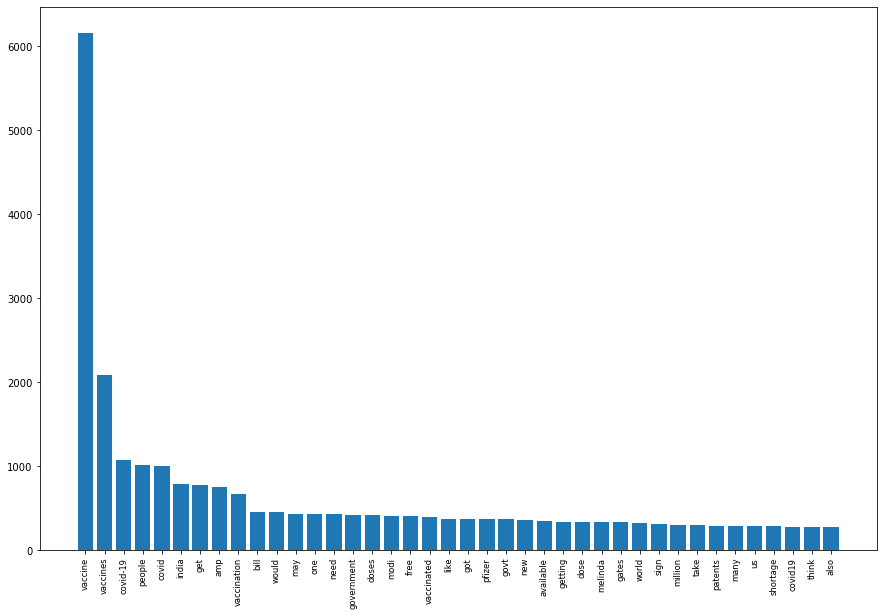

In [128]:
fig, ax0 = plt.subplots(figsize=(15,10))
ax0.bar(count_sort.index, count_sort['counts'])
plt.xticks(rotation=90, fontsize = 'small')
plt.show()

After stemming the words to increase accuracy the count is relative unchanged with the most frequent words being 'vaccine', 'get' and 'covid-19' which is presumably a hashtag. 

In [129]:
stemmer = nltk.stem.SnowballStemmer("english")
stems = []
for i in en_only['no_punct']:
    stems.append([stemmer.stem(word) for word in i])
    
en_only['stemmed'] = stems

In [130]:
freq2 = [FreqDist(x) for x in en_only['stemmed']]
en_only['freqs2'] = freq2
en_only['freqs2']

1        {'cnn': 1, 'covid-19': 1, 'case': 1, 'report':...
2        {'mla_sudhakar': 1, 'hello': 1, 'sir': 1, 'vis...
3        {'wolfofnewstreet': 1, 'hmm': 1, 'abeg': 1, 'm...
5        {'captmarkkelli': 1, 'import': 1, 'news': 1, '...
6        {'jedi_fu': 1, 'appar': 1, 'peopl': 1, 'make':...
                               ...                        
13484    {'zainrizvi': 1, 'gregggonsalv': 1, 'apoorva_n...
13487    {'watch': 1, 'taguig': 1, 'healthcar': 1, 'wor...
13490    {'mohanrajtn': 1, 'short': 1, 'vaccin': 1, 'ad...
13491    {'drembrac': 1, 'vaccin': 1, 'injur': 1, 'us':...
13492    {'lukewsavag': 1, 'wish': 1, 'bill': 1, 'gate'...
Name: freqs2, Length: 10075, dtype: object

In [131]:
en_only['f2_counts'] = [Counter(x) for x in en_only['freqs2']]
en_only['f2_counts'][0]

KeyError: 0

In [133]:
wordcounts = Counter()
for i in en_only['f2_counts']:
    wordcounts += i

In [134]:
counts2 = pd.DataFrame.from_dict(dict(wordcounts), orient='index')
counts2

,0
cnn,39
covid-19,1071
case,161
report,160
worldwid,85
...,...
zainrizvi,1
bidasolusyon,1
//t.co/4nzkb1rrmi,1
mohanrajtn,1


In [135]:
counts2 = counts2.rename(columns = {0: 'counts'})
counts2

,counts
cnn,39
covid-19,1071
case,161
report,160
worldwid,85
...,...
zainrizvi,1
bidasolusyon,1
//t.co/4nzkb1rrmi,1
mohanrajtn,1


In [136]:
count_sort2 = counts2.sort_values('counts', ascending = False)[:20]
count_sort2

,counts
vaccin,9543
get,1203
covid-19,1071
peopl,1021
covid,1002
india,797
dose,766
amp,753
need,560
countri,502


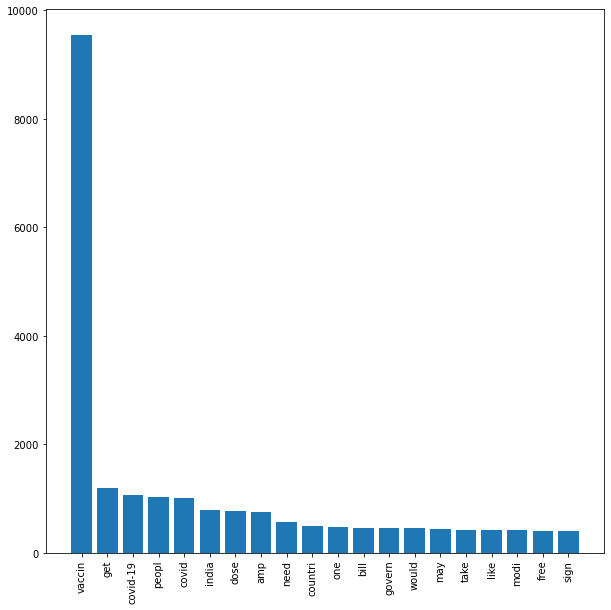

In [137]:
fig, ax1 = plt.subplots(figsize=(10,10))
ax1.bar(count_sort2.index, count_sort2['counts'])
plt.xticks(rotation=90, fontsize = 'medium')
plt.show()

I ran a word grequency analysis on the tweets to get a quick idea of the most mentioned words within the tweets, this also allowed me to quickly gage that the conversations were actually geared towards the COVID-19 vaccine and not another vaccine or just talking about COVID-19 in general. 

In [138]:
analyser = SentimentIntensityAnalyzer()
warnings.filterwarnings('ignore')

In [139]:
print(en_only['text'][3])
print(analyser.polarity_scores(en_only['text'][3]))

RT @wolfofnewstreet: Hmm, abeg what did Melinda find out? I've already taken the vaccine o, hay God
{'neg': 0.0, 'neu': 0.884, 'pos': 0.116, 'compound': 0.2732}


In [140]:
en_only['vader_scores'] = [analyser.polarity_scores(x) for x in en_only['text']]
en_only['vader_scores'].head(20)

1     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
3     {'neg': 0.0, 'neu': 0.884, 'pos': 0.116, 'comp...
5     {'neg': 0.088, 'neu': 0.84, 'pos': 0.072, 'com...
6     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
7     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
8     {'neg': 0.146, 'neu': 0.634, 'pos': 0.22, 'com...
9     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
10    {'neg': 0.082, 'neu': 0.817, 'pos': 0.101, 'co...
11    {'neg': 0.153, 'neu': 0.847, 'pos': 0.0, 'comp...
14    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
15    {'neg': 0.077, 'neu': 0.813, 'pos': 0.11, 'com...
16    {'neg': 0.073, 'neu': 0.586, 'pos': 0.34, 'com...
17    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
18    {'neg': 0.139, 'neu': 0.584, 'pos': 0.277, 'co...
19    {'neg': 0.208, 'neu': 0.717, 'pos': 0.075, 'co...
20    {'neg': 0.0, 'neu': 0.862, 'pos': 0.138, 'comp...
22    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'comp

In [141]:
en_only['pos'] = [x['pos'] for x in en_only['vader_scores']]
len(en_only['pos'])

10075

In [142]:
en_only['neg'] = [x['neg'] for x in en_only['vader_scores']]
len(en_only['neg'])

10075

In [143]:
en_only['compound'] = [x['compound'] for x in en_only['vader_scores']]
en_only['compound']

1        0.0000
2        0.0000
3        0.2732
5       -0.1027
6        0.0000
          ...  
13484   -0.0258
13487    0.0000
13490    0.4389
13491   -0.6774
13492    0.5574
Name: compound, Length: 10075, dtype: float64

In [161]:
import numpy as np

In [163]:
condition_1 = en_only['compound'] >= 0.05
condition_2 = (en_only['compound'] > -0.05) & (en_only['compound'] < 0.05)
condition_3 = en_only['compound'] <= -0.05
conditions = [condition_1, condition_2, condition_3]
choices = ["Positive", "Nuetral", "Negative"]
en_only["Sentiment"] = np.select(conditions, choices, default="")
en_only

,Unnamed: 0,id,text,author_id,lang,withheld,geo,text_lower,tokens,filtered,...,freqs1,f1_counts,stemmed,freqs2,f2_counts,vader_scores,pos,neg,compound,Sentiment
1,1,1389462583250329601,RT @CNN: There have been more Covid-19 cases r...,452473850,en,NaN,NaN,rt @cnn: there have been more covid-19 cases r...,"[rt, @, cnn, :, there, have, been, more, covid...","[@, cnn, :, covid-19, cases, reported, worldwi...",...,"{'cnn': 1, 'covid-19': 1, 'cases': 1, 'reporte...","{'cnn': 1, 'covid-19': 1, 'cases': 1, 'reporte...","[cnn, covid-19, case, report, worldwid, past, ...","{'cnn': 1, 'covid-19': 1, 'case': 1, 'report':...","{'cnn': 1, 'covid-19': 1, 'case': 1, 'report':...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.000,0.0000,Nuetral
2,2,1389462582432464899,"@mla_sudhakar Hello sir, I visited one of the ...",3401360113,en,NaN,NaN,"@mla_sudhakar hello sir, i visited one of the ...","[@, mla_sudhakar, hello, sir, ,, i, visited, o...","[@, mla_sudhakar, hello, sir, ,, visited, one,...",...,"{'mla_sudhakar': 1, 'hello': 1, 'sir': 1, 'vis...","{'mla_sudhakar': 1, 'hello': 1, 'sir': 1, 'vis...","[mla_sudhakar, hello, sir, visit, one, bbmp, c...","{'mla_sudhakar': 1, 'hello': 1, 'sir': 1, 'vis...","{'mla_sudhakar': 1, 'hello': 1, 'sir': 1, 'vis...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.000,0.0000,Nuetral
3,3,1389462582268944385,"RT @wolfofnewstreet: Hmm, abeg what did Melind...",4122258611,en,NaN,NaN,"rt @wolfofnewstreet: hmm, abeg what did melind...","[rt, @, wolfofnewstreet, :, hmm, ,, abeg, what...","[@, wolfofnewstreet, :, hmm, ,, abeg, melinda,...",...,"{'wolfofnewstreet': 1, 'hmm': 1, 'abeg': 1, 'm...","{'wolfofnewstreet': 1, 'hmm': 1, 'abeg': 1, 'm...","[wolfofnewstreet, hmm, abeg, melinda, find, ve...","{'wolfofnewstreet': 1, 'hmm': 1, 'abeg': 1, 'm...","{'wolfofnewstreet': 1, 'hmm': 1, 'abeg': 1, 'm...","{'neg': 0.0, 'neu': 0.884, 'pos': 0.116, 'comp...",0.116,0.000,0.2732,Positive
5,5,1389462581388087305,RT @CaptMarkKelly: Important news: You can now...,820384458633191424,en,NaN,NaN,rt @captmarkkelly: important news: you can now...,"[rt, @, captmarkkelly, :, important, news, :, ...","[@, captmarkkelly, :, important, news, :, head...",...,"{'captmarkkelly': 1, 'important': 1, 'news': 1...","{'captmarkkelly': 1, 'important': 1, 'news': 1...","[captmarkkelli, import, news, head, state-run,...","{'captmarkkelli': 1, 'import': 1, 'news': 1, '...","{'captmarkkelli': 1, 'import': 1, 'news': 1, '...","{'neg': 0.088, 'neu': 0.84, 'pos': 0.072, 'com...",0.072,0.088,-0.1027,Negative
6,6,1389462580201152518,RT @jedi_fu: Apparently the people making mone...,1348965994388201472,en,NaN,NaN,rt @jedi_fu: apparently the people making mone...,"[rt, @, jedi_fu, :, apparently, the, people, m...","[@, jedi_fu, :, apparently, people, making, mo...",...,"{'jedi_fu': 1, 'apparently': 1, 'people': 1, '...","{'jedi_fu': 1, 'apparently': 1, 'people': 1, '...","[jedi_fu, appar, peopl, make, money, vaccin, g...","{'jedi_fu': 1, 'appar': 1, 'peopl': 1, 'make':...","{'jedi_fu': 1, 'appar': 1, 'peopl': 1, 'make':...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.000,0.0000,Nuetral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13484,1,1389456286853435393,RT @zainrizvi: @gregggonsalves @apoorva_nyc @J...,538467434,en,NaN,NaN,rt @zainrizvi: @gregggonsalves @apoorva_nyc @j...,"[rt, @, zainrizvi, :, @, gregggonsalves, @, ap...","[@, zainrizvi, :, @, gregggonsalves, @, apoorv...",...,"{'zainrizvi': 1, 'gregggonsalves': 1, 'apoorva...","{'zainrizvi': 1, 'gregggonsalves': 1, 'apoorva...","[zainrizvi, gregggonsalv, apoorva_nyc, jennife...","{'zainrizvi': 1, 'gregggonsalv': 1, 'apoorva_n...","{'zainrizvi': 1, 'gregggonsalv': 1, 'apoorva_n...","{'neg': 0.064, 'neu': 0.936, 'pos': 0.0, 'comp...",0.000,0.064,-0.0258,Nuetral
13487,4,1389456285385383937,WATCH | Taguig healthcare workers begin to adm...,823349574739734528,en,NaN,NaN,watch | taguig healthcare workers begin to adm...,"[wa

In [167]:
sentiment = en_only.groupby('Sentiment').count()
sentiment

,Unnamed: 0,id,text,author_id,lang,withheld,geo,text_lower,tokens,filtered,no_punct,freqs1,f1_counts,stemmed,freqs2,f2_counts,vader_scores,pos,neg,compound
Sentiment,,,,,,,,,,,,,,,,,,,,
Negative,3027,3027,3027,3027,3027,5,14,3027,3027,3027,3027,3027,3027,3027,3027,3027,3027,3027,3027,3027
Nuetral,3105,3105,3105,3105,3105,28,7,3105,3105,3105,3105,3105,3105,3105,3105,3105,3105,3105,3105,3105
Positive,3943,3943,3943,3943,3943,9,16,3943,3943,3943,3943,3943,3943,3943,3943,3943,3943,3943,3943,3943


In [144]:
from scipy import stats

In [145]:
stats.describe(en_only['compound']).mean

0.03948882382133995

Here I ran a vader sentiment analysis to determine the general attitude towards the vaccine in the tweets. 

## Findings

After doing a vader analysis I found that about 30% of the tweets are positive towards the vaccine, about 31% of the tweets are neutral towards the vaccine, and 39% of the tweets are negative towards the vaccine. Overall the mean of the compound vader score was 0.039 which is considered neutral. The CDC is reporting that currrently 31.8% of the US population have been fully vacinated and 44.4% of the population have had at least one dose. That leaves about 24% of the population that has not recieved the vaccine. With out further in depth analysis you could conclude that the 39% of negative tweets about the vaccine is a very vocal minority that is amplified past the actual number of people not recieving the vaccine. 

#### Limitations and Further Steps

The Vader sentiment analysis that I ran does not take into account all of the variables of the tweets, this tweet set also includes factual tweets from governement and non-profit organizations, not just people so that would skew the overall sentiment towards the vaccine to a neutral stance because the information is purely information and not opinionated. To further this idea collecting a larger data set from Twitter and then defing a stricter set of guildlines for cleaning the data set would be needed for a result that could be considered truely accurate.